<a href="https://colab.research.google.com/github/Oleksii-Adamov/text-detection-recognition-project/blob/main/Kirill_notebooks/visualisation_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/paulgavrikov/visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-irookre2
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-irookre2
     |████████████████████████████████| 989 kB 4.1 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=bbf3234a83f55536472f64096c90b6e1227fbd1ff98a3e722ce0adc5ccb9a239
  Stored in directory: /tmp/pip-ephem-wheel-cache-shwzveb_/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, InputLayer, ZeroPadding2D, Permute, Lambda
import tensorflow as tf
from tensorflow import keras
from collections import defaultdict
import visualkeras
from PIL import ImageFont
import numpy as np

In [ ]:
DEFAULT_BUILD_PARAMS = {
    "height": 31,
    "width": 200,
    "color": False,
    "filters": (64, 128, 256, 256, 512, 512, 512),
    "rnn_units": (128, 128),
    "dropout": 0.25,
    "rnn_steps_to_discard": 2,
    "pool_size": 2,
    "stn": True,
}

filters = DEFAULT_BUILD_PARAMS["filters"]
pool_size = DEFAULT_BUILD_PARAMS["pool_size"]
rnn_units = DEFAULT_BUILD_PARAMS["rnn_units"]
dropout = DEFAULT_BUILD_PARAMS["dropout"]
rnn_steps_to_discard = DEFAULT_BUILD_PARAMS["rnn_steps_to_discard"]
width = DEFAULT_BUILD_PARAMS["width"]
height = DEFAULT_BUILD_PARAMS["height"]
stn = DEFAULT_BUILD_PARAMS["stn"]
color = DEFAULT_BUILD_PARAMS["color"]
alphabet = 'qwertyuiopasdfghjklzxcvbnm'

def _repeat(x, num_repeats):
    ones = tf.ones((1, num_repeats), dtype="int32")
    x = tf.reshape(x, shape=(-1, 1))
    x = tf.matmul(x, ones)
    return tf.reshape(x, [-1])

def _meshgrid(height, width):
    x_linspace = tf.linspace(-1.0, 1.0, width)
    y_linspace = tf.linspace(-1.0, 1.0, height)
    x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
    x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
    y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
    ones = tf.ones_like(x_coordinates)
    indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
    return indices_grid

def _transform(inputs):
    locnet_x, locnet_y = inputs
    output_size = locnet_x.shape[1:]
    batch_size = tf.shape(locnet_x)[0]
    height = tf.shape(locnet_x)[1]
    width = tf.shape(locnet_x)[2]
    num_channels = tf.shape(locnet_x)[3]

    locnet_y = tf.reshape(locnet_y, shape=(batch_size, 2, 3))

    locnet_y = tf.reshape(locnet_y, (-1, 2, 3))
    locnet_y = tf.cast(locnet_y, "float32")

    output_height = output_size[0]
    output_width = output_size[1]
    indices_grid = _meshgrid(output_height, output_width)
    indices_grid = tf.expand_dims(indices_grid, 0)
    indices_grid = tf.reshape(indices_grid, [-1])  # flatten?
    indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
    indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

    transformed_grid = tf.matmul(locnet_y, indices_grid)
    x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
    y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
    x = tf.reshape(x_s, [-1])
    y = tf.reshape(y_s, [-1])

    # Interpolate
    height_float = tf.cast(height, dtype="float32")
    width_float = tf.cast(width, dtype="float32")

    output_height = output_size[0]
    output_width = output_size[1]

    x = tf.cast(x, dtype="float32")
    y = tf.cast(y, dtype="float32")
    x = 0.5 * (x + 1.0) * width_float
    y = 0.5 * (y + 1.0) * height_float

    x0 = tf.cast(tf.floor(x), "int32")
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), "int32")
    y1 = y0 + 1

    max_y = tf.cast(height - 1, dtype="int32")
    max_x = tf.cast(width - 1, dtype="int32")
    zero = tf.zeros([], dtype="int32")

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    flat_image_dimensions = width * height
    pixels_batch = tf.range(batch_size) * flat_image_dimensions
    flat_output_dimensions = output_height * output_width
    base = _repeat(pixels_batch, flat_output_dimensions)
    base_y0 = base + y0 * width
    base_y1 = base + y1 * width
    indices_a = base_y0 + x0
    indices_b = base_y1 + x0
    indices_c = base_y0 + x1
    indices_d = base_y1 + x1

    flat_image = tf.reshape(locnet_x, shape=(-1, num_channels))
    flat_image = tf.cast(flat_image, dtype="float32")
    pixel_values_a = tf.gather(flat_image, indices_a)
    pixel_values_b = tf.gather(flat_image, indices_b)
    pixel_values_c = tf.gather(flat_image, indices_c)
    pixel_values_d = tf.gather(flat_image, indices_d)

    x0 = tf.cast(x0, "float32")
    x1 = tf.cast(x1, "float32")
    y0 = tf.cast(y0, "float32")
    y1 = tf.cast(y1, "float32")

    area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
    area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
    area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
    area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
    transformed_image = tf.add_n(
        [
            area_a * pixel_values_a,
            area_b * pixel_values_b,
            area_c * pixel_values_c,
            area_d * pixel_values_d,
        ]
    )
    # Finished interpolation

    transformed_image = tf.reshape(
        transformed_image, shape=(batch_size, output_height, output_width, num_channels)
    )
    return transformed_image

inputs = keras.layers.Input((width, height, 1))

x = keras.layers.Permute((2, 1, 3))(inputs)
x = keras.layers.Lambda(lambda x: x[:, :, ::-1])(x)

x = keras.layers.Conv2D(filters[0], (3, 3), activation="relu", padding="same", name="conv_1")(x)
x = keras.layers.Conv2D(filters[1], (3, 3), activation="relu", padding="same", name="conv_2")(x)
x = keras.layers.Conv2D(filters[2], (3, 3), activation="relu", padding="same", name="conv_3")(x)
x = keras.layers.BatchNormalization(name="bn_3")(x)

x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name="maxpool_3")(x)
x = keras.layers.Conv2D(filters[3], (3, 3), activation="relu", padding="same", name="conv_4")(x)
x = keras.layers.Conv2D(filters[4], (3, 3), activation="relu", padding="same", name="conv_5")(x)
x = keras.layers.BatchNormalization(name="bn_5")(x)

x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name="maxpool_5")(x)
x = keras.layers.Conv2D(filters[5], (3, 3), activation="relu", padding="same", name="conv_6")(x)
x = keras.layers.Conv2D(filters[6], (3, 3), activation="relu", padding="same", name="conv_7")(x)
x = keras.layers.BatchNormalization(name="bn_7")(x)

if stn:
    stn_input_output_shape = (width // pool_size**2,height // pool_size**2,filters[6],)
    stn_input_layer = keras.layers.Input(shape=stn_input_output_shape)
    locnet_y = keras.layers.Conv2D(16, (5, 5), padding="same", activation="relu")(stn_input_layer)
    locnet_y = keras.layers.Conv2D(32, (5, 5), padding="same", activation="relu")(locnet_y)
    locnet_y = keras.layers.Flatten()(locnet_y)
    locnet_y = keras.layers.Dense(64, activation="relu")(locnet_y)
    locnet_y = keras.layers.Dense(6,weights=[np.zeros((64, 6), dtype="float32"),np.array([[1, 0, 0], [0, 1, 0]], dtype="float32").flatten(),],)(locnet_y)
    localization_net = keras.models.Model(inputs=stn_input_layer, outputs=locnet_y)
    x = keras.layers.Lambda(_transform, output_shape=stn_input_output_shape)([x, localization_net(x)])

x = keras.layers.Reshape(target_shape=(width // pool_size**2,(height // pool_size**2) * filters[-1],),name="reshape",)(x)
x = keras.layers.Dense(rnn_units[0], activation="relu", name="fc_9")(x)

rnn_1_forward = keras.layers.LSTM(rnn_units[0],kernel_initializer="he_normal",return_sequences=True,name="lstm_10",)(x)
rnn_1_back    = keras.layers.LSTM(rnn_units[0],kernel_initializer="he_normal",return_sequences=True,go_backwards=True,name="lstm_10_back",)(x)

rnn_1_add     = keras.layers.Add()([rnn_1_forward, rnn_1_back])

rnn_2_forward = keras.layers.LSTM(rnn_units[1],kernel_initializer="he_normal",return_sequences=True,name="lstm_11",)(rnn_1_add)
rnn_2_back    = keras.layers.LSTM(rnn_units[1],kernel_initializer="he_normal",return_sequences=True,go_backwards=True,name="lstm_11_back",)(rnn_1_add)

x = keras.layers.Concatenate()([rnn_2_forward, rnn_2_back])
backbone = keras.models.Model(inputs=inputs, outputs=x)

x = keras.layers.Dropout(dropout, name="dropout")(x)
x = keras.layers.Dense(len(alphabet) + 1, kernel_initializer="he_normal", activation="softmax",name="fc_12",)(x)
x = keras.layers.Lambda(lambda x: x[:, rnn_steps_to_discard:])(x)

model = keras.models.Model(inputs=inputs, outputs=x)

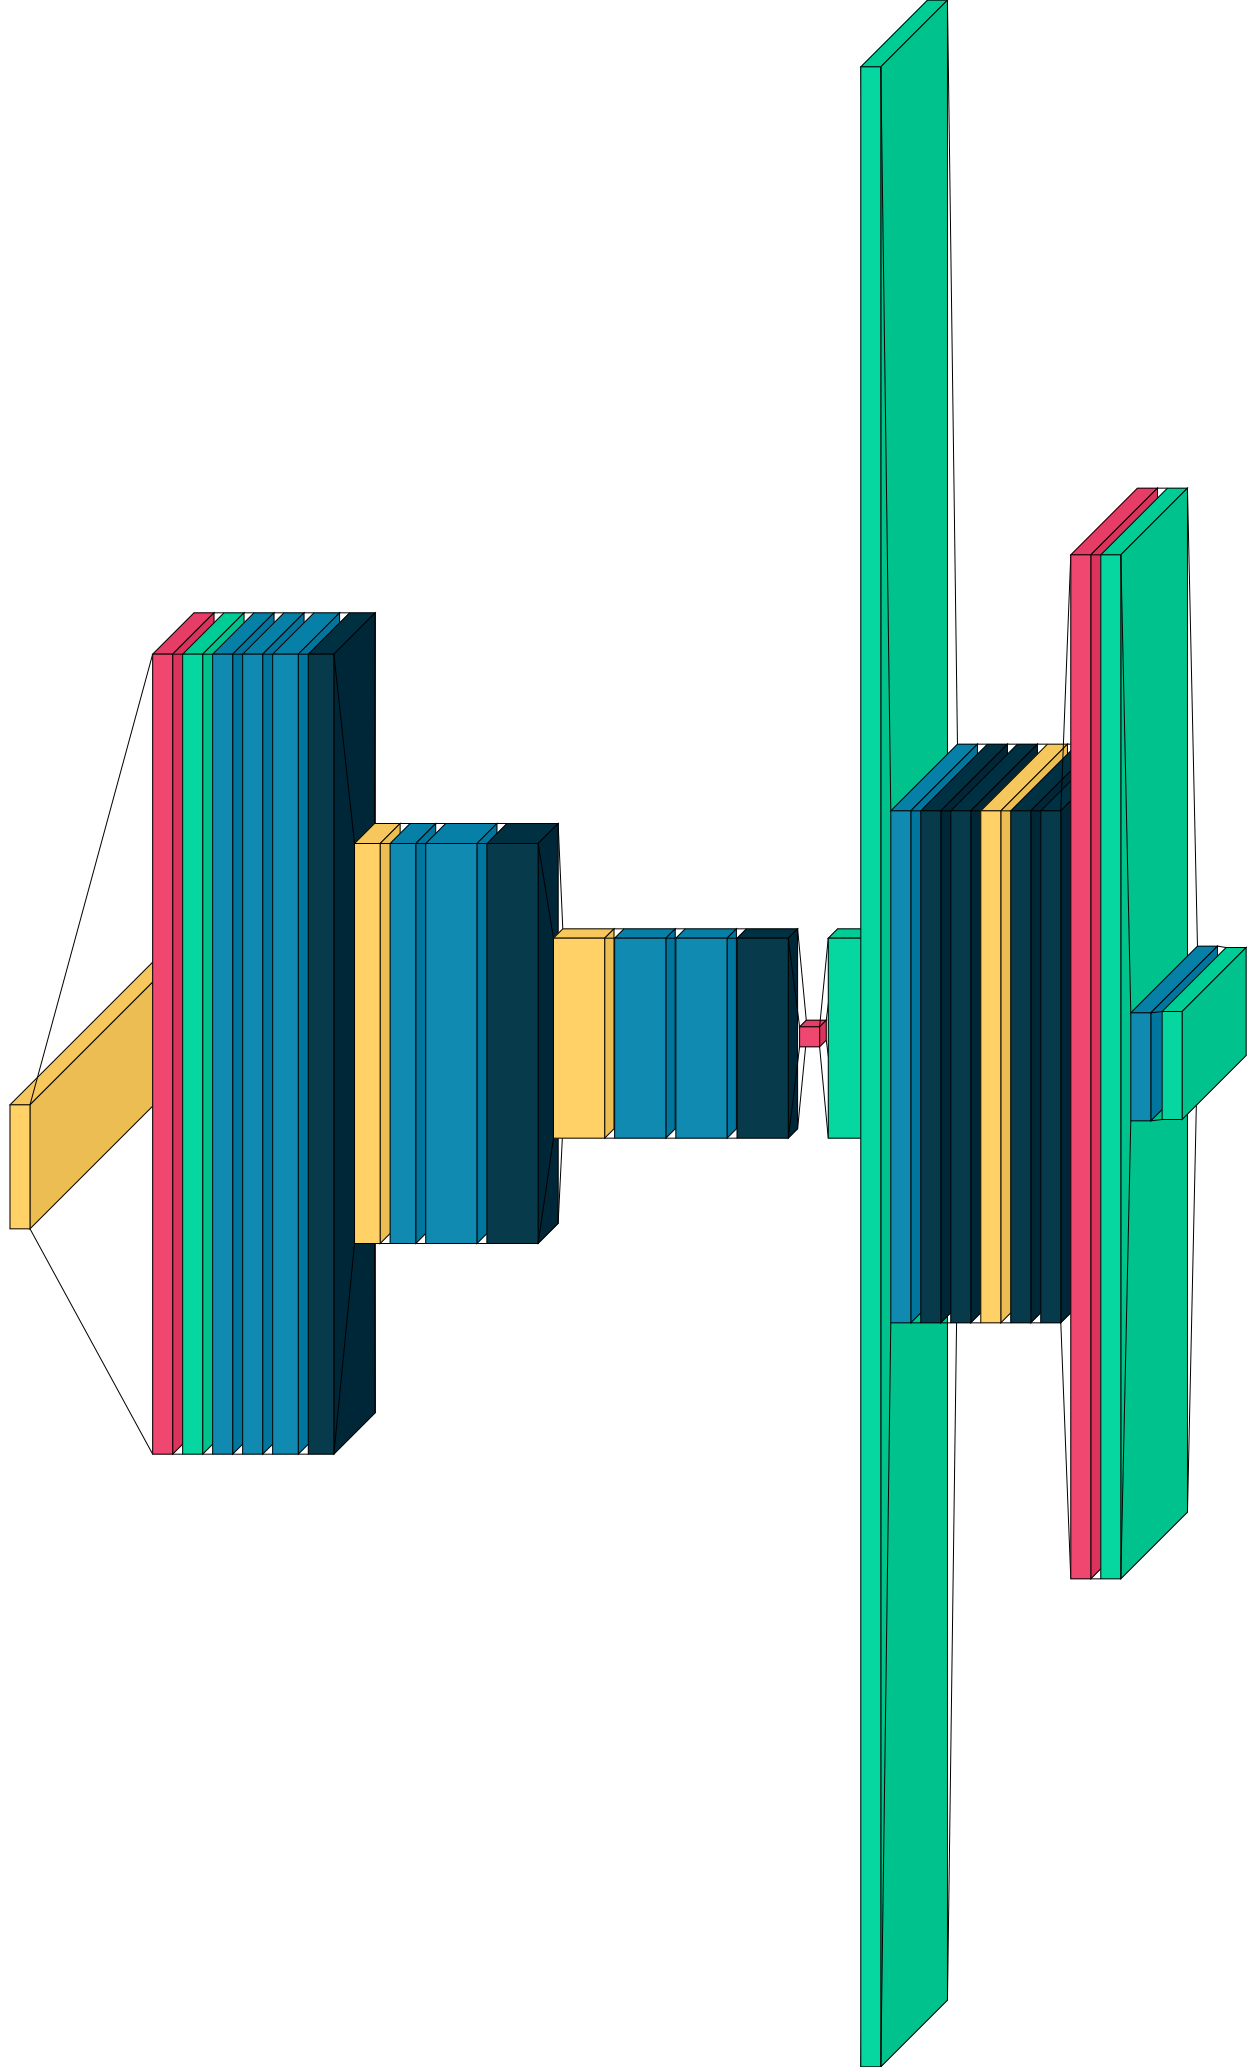

In [ ]:
visualkeras.layered_view(model, legend=False,  to_file='/content/figures/vgg17.png')